In [1]:
import pandas as pd
import tweepy
import requests
import datetime
import json
import matplotlib.pyplot as plt
from Classes import Data_crawl
from functions import *

### My Access Keys for Tweepy

In [2]:
api_key = 'I3N75MY5qJxCvSrLWe0ZG4vQk'
api_key_secret = 'Q3GC8Vr6F2FNqwh7v8rWoDNnA1Qqnn4RjkJ6STVtAQLamw4qCs'
bearer_token = 'AAAAAAAAAAAAAAAAAAAAAIPvbAEAAAAApt3kcfjyiVBOLVWMbi1Fu6CLL24%3DuIMwpFYplQqMd68VXXv4eU954tnOQu5vljRnV3xL292k4F5sFR'
access_token = '1467171706754453504-EJx2MzY1RtEGHXf3hqBZkANnsc4hA2'
access_token_secret = 'VpVdfP1WhID2nas76BXRTMdXXOTvx1BPO1J9LDYs9QM65'

In [3]:
token = [
'AAAAAAAAAAAAAAAAAAAAAIPvbAEAAAAAh3nRGhJ1HJjYHAwyxn7F5tm91js%3DpUaTtSLOgLxWFGdDaL2cDgHbJyiYQt8UMbWe8s9hfO8UIBK3xu', # mine
'AAAAAAAAAAAAAAAAAAAAACHvcgEAAAAA9lDgALcD%2FZRxz%2BFrzuc6B7IxJqc%3DnBTsObUCrmc50dlBlB81QMnqnab8oj5Oo7uy4uXMi7vVUOEJAu',
'AAAAAAAAAAAAAAAAAAAAAOvxbAEAAAAAOu%2FTOVHN5ocKWaChbnjZwI%2FoGdw%3DC1laLqLeCuXiwjg1bkV7kEVMY3pd3kZHDA4TKeRjcR89kKQPeR',
'AAAAAAAAAAAAAAAAAAAAAC3ucgEAAAAANkLeJqeojqdGXtbsGknDrLiZuJ4%3DueRC8NneqPUawhC3rkI83DXgUk68poiPHc60YAMtKqDr9NFTHs',
'AAAAAAAAAAAAAAAAAAAAAHfucgEAAAAAWrhXRgMpo%2Fj7fHl9uqSiUlklY5M%3DQWmApmhHTWG0LcdB77fiYOTnB8mbpU4HcPLMeWl6mQmZr60mKZ',
'AAAAAAAAAAAAAAAAAAAAAJKnJgEAAAAAgpYwO66pBtdDUcwjHYnWbMY1ow8%3DJgCTSnmkqVE5M0ywnyoSvMX1Ywpz2ivYnONwQ0Aro7bgby6TUm',
'AAAAAAAAAAAAAAAAAAAAAJaOeQEAAAAAyvSZWQ6m9q4SaMT1t1WCH%2FOymj0%3DVgRvLEP51YERK403i2pk5JU05Lu0vXppgQHxvhhxcBIkftu1FH'
]

## <font color="pink">Biden tweets crawling </font> ##



In [4]:
download = False # 需不需要抓資料，FALSE 的話載入本地資料

dataset = Data_crawl(token=token)
query = 'from:POTUS -is:retweet' 
tweet_fields = ['author_id', 'created_at']
today  = str(datetime.date.today()) # 用當天日期當作檔案名稱
file_path = 'Biden/' + today + '/'

if download:
    today  = str(datetime.date.today()) # 用當天日期當作檔案名稱
    tweet_df = dataset.Get_Tweets_Dataframe(
        query=query,
        tweet_fields=tweet_fields
    )
else:
    file_path = 'Biden/2022-10-10/'
    today = '2022-10-10'
    tweet_df = pd.read_excel(file_path + '2022-10-10.xlsx')
    dataset.Get_Tweets_Dataframe(tweet_df=tweet_df, wanna_download=download)
tweet_df.tail(n=8)

,Unnamed: 0,id,author_id,created_at,text,edit_history_tweet_ids
49,49,1577058416748634124,1349149096909668363,2022-10-03T22:10:01.000Z,All of America is with Puerto Rico as they rec...,['1577058416748634124']
50,50,1577043467397644288,1349149096909668363,2022-10-03T21:10:37.000Z,"We’re investing in Puerto Rico’s roads, bridge...",['1577043467397644288']
51,51,1577017284807335941,1349149096909668363,2022-10-03T19:26:34.000Z,I’m determined to help Puerto Rico rebuild str...,['1577017284807335941']
52,52,1577011433040117763,1349149096909668363,2022-10-03T19:03:19.000Z,Join me as I deliver remarks on Puerto Rico di...,['1577011433040117763']
53,53,1576980402090156042,1349149096909668363,2022-10-03T17:00:01.000Z,I made clear my commitment to supporting the p...,['1576980402090156042']
54,54,1576980400538263552,1349149096909668363,2022-10-03T17:00:01.000Z,This funding builds on our work to support Pue...,['1576980400538263552']
55,55,1576980398596411393,1349149096909668363,2022-10-03T17:00:00.000Z,I said we'd be with the people of Puerto Rico ...,['1576980398596411393']
56,56,1576956856022491136,1349149096909668363,2022-10-03T15:26:27.000Z,"Jill and I are headed to Ponce, Puerto Rico.\n...",['1576956856022491136']


## <font color="pink">依照 tweet ID 尋找每篇推文的 retweeters</font> 

> * 使用 JSON/XLSX 格式儲存 retweeters
> * 針對每篇 tweet 建立兩個 list，分別把抓到的 ID、UserName 存進 Retweeter_List
> * 將抓取的時間範圍寫在最前面
>
> * <font color=#FF6600> 要用 paginator 抓 retweeters，否則會抓不超過 100 個
> * 練習檔案讀寫務必記得拿 White House，否則複寫以後檔案會消失 (2022/10/06 )  </font>


In [5]:
if download:
    dataset.Get_Retweeters_MultiThread(filename=file_path)

## <font color="pink"> 分布圖 & Target User </font> 

- 依照每篇 tweet 看一下 retweet count ，畫成 bar chart.

- 依照每個 user 轉推的篇數畫出 bar chart，<font color=#FFD382> X軸為 轉推1,2,3... 的篇數，Y軸為人數 </font>
- 分布圖出來以後，設一個底線，把轉推篇數低於這個底線的 user 踢掉，留下的就是 target user

In [6]:
Need_Union = False # if u need to unions the files, set as True
retweeter_dict = dict() # keys:tweet id, value:list of retweeters

if Need_Union:
    retweet_file_list = list() # storing all files name u want to union
    for i in range(len(token)):
        filename = file_path + str(i) + '_retweeters.json'
        retweet_file_list.append(filename)
    retweeter_dict = union_JSON_files(file_list = retweet_file_list)

else: # u wanna load the retweeter json file that has already unioned.
    with open(file_path + today + '_retweeters.json', 'r') as f:
        json_file = json.load(f)
        for tweet_id in json_file:
            retweeter_dict[tweet_id] = json_file[tweet_id]

print("Total tweets :", len(retweeter_dict.keys()))

Total tweets : 57


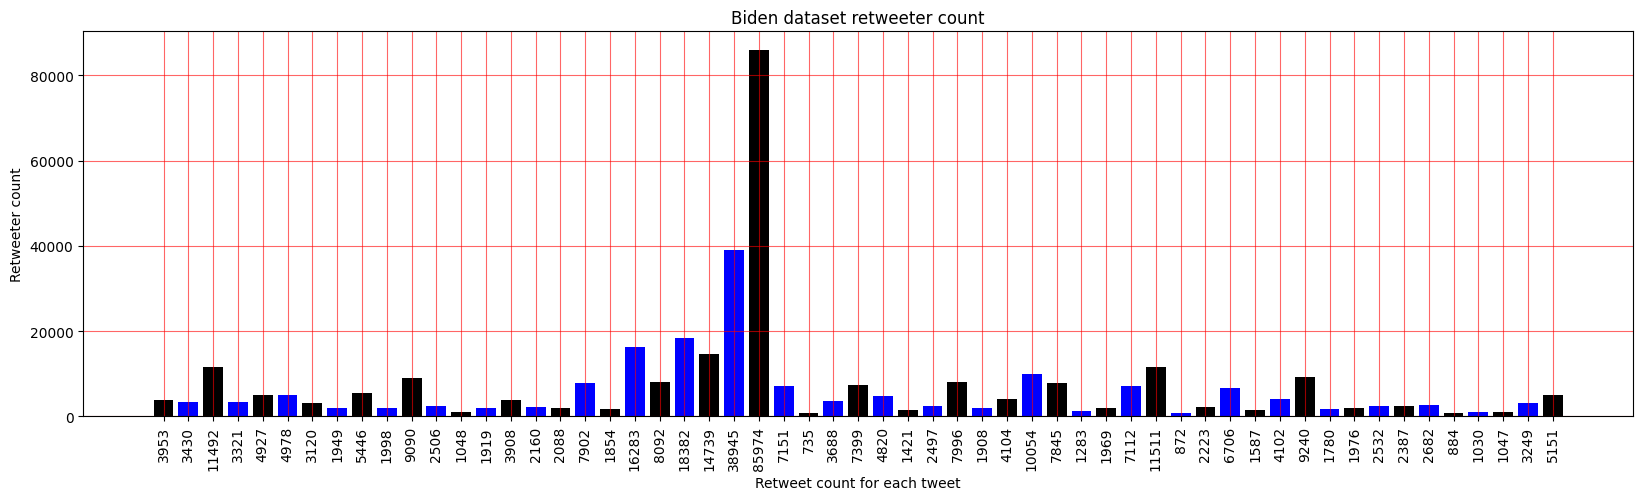

In [7]:
# retweet count for each tweet -- bar chart
count = list()
for id in retweeter_dict.keys():
    count.append(len(retweeter_dict[id]))
retweet_count = list(map(str, count))

plt.figure(figsize = (20,5))
plt.title('Biden dataset retweeter count')
plt.bar(retweet_count, count, color=['black', 'blue'], width=0.8, align='center')
plt.grid(True,color='r',alpha=0.6)
plt.xlabel('Retweet count for each tweet')
plt.ylabel('Retweeter count')
plt.xticks(rotation='vertical')
plt.show()

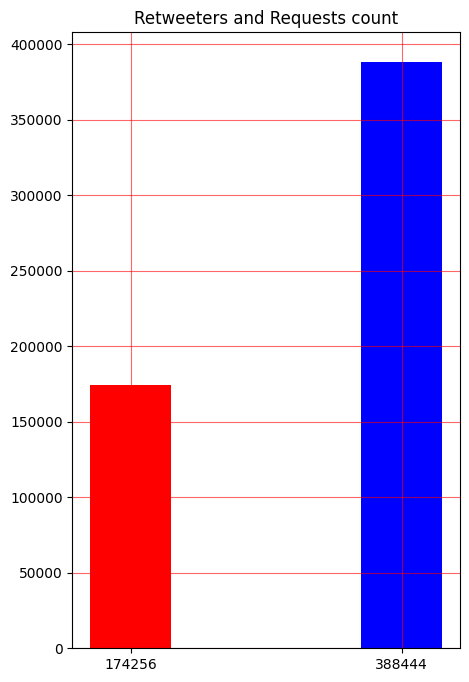

In [8]:
# Union the retweeter lists, filtering the repeated id

retweeters = set()
requests_count = 0
for i in retweeter_dict:
    retweeter_list = set(retweeter_dict[i])
    requests_count += len(retweeter_list)
    retweeters |= retweeter_list # Union into retweeters

# And also, see the ratio of retweeters and requests count --> bar chart
plt.figure(figsize = (5,8))
plt.title('Retweeters and Requests count')
plt.bar([str(len(retweeters)), str(requests_count)], [len(retweeters), requests_count],color=['red', 'blue'], width=0.3, align='center')
plt.grid(True,color='r',alpha=0.6)
plt.show()

## Target User
- 踢掉 retweet 篇數過少的 users，剩下的對象就是 target users.
- 接著再用 target users 去蒐集相對應的 followers.
- Negative Sampling 可能要上.

In [9]:
# start finding retweets count of each user
user_retweet_count = dict()
result = UserRetweetCount_MultiCore(
    retweeter_dict=retweeter_dict, 
    retweeters=list(retweeters), 
    parallelism=12, 
    requests_count=requests_count
)
# parralle degree = 15, 2m19.3s
# parralle degree = 9, 2m43.4s

Parrelle degree:  12
Start dispatching Multi-Process....
Start running all sub-process......
Wait for resulst of all sub-process......
Jobs done ! Start union all results


In [10]:
# start statistics retweet count

"""
    Retweet count from 1 to len(how many tweets)
    show_list : first element represent 'how many users retweet 1 tweet', so are the rests.

"""
label = [str(i) for i in range(1,58,1)]
show_list = [0 for i in range(tweet_df.shape[0])]

for user in result.keys():
    index = result[user]
    show_list[index-1] += 1

Total users: 174256


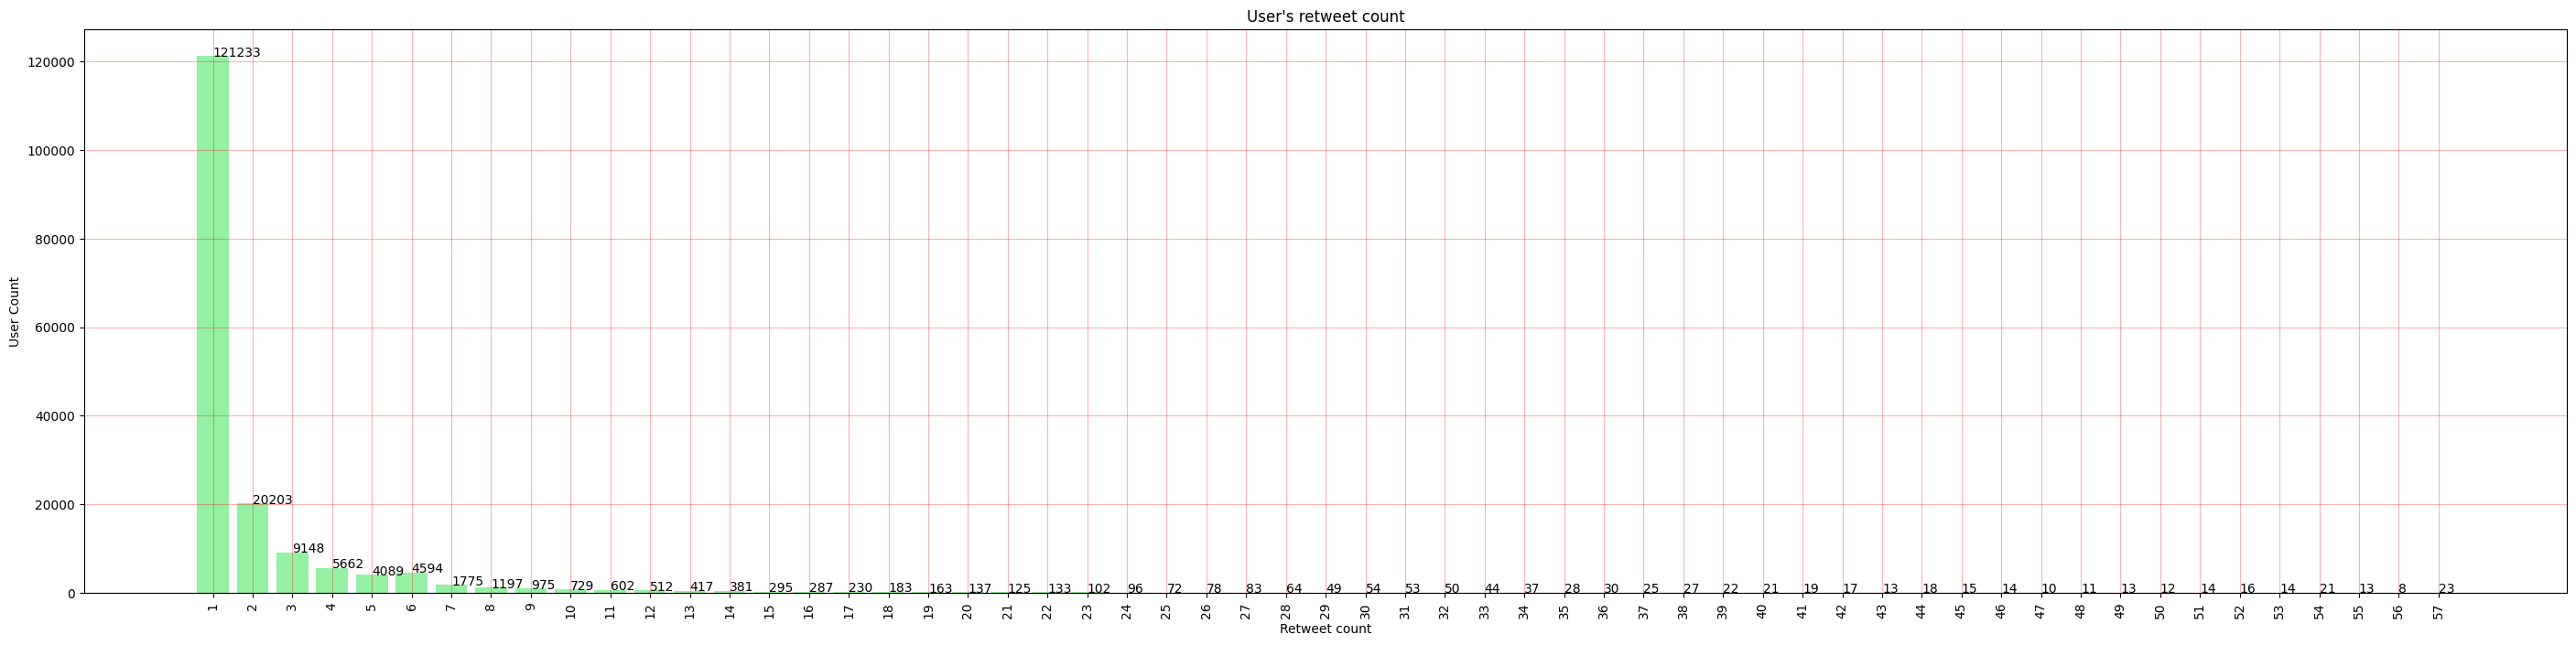

In [11]:
# Draw a bar plot to see
print("Total users: %d" % len(retweeters))
color = (0.3, 0.9, 0.4, 0.6)
plt.figure(figsize = (35,8))
plt.title("User's retweet count")
plt.bar(label, show_list, color=color, width=0.8, align='center')
plt.grid(True,color='r',alpha=0.3)
plt.xlabel('Retweet count')
plt.ylabel('User Count')
plt.xticks(rotation='vertical')
for index, value in enumerate(show_list):
    plt.text(index, value, str(value))
plt.show()

Total users : 174256
Deleting users of retweet counts lower than 4 : 156246
Total of target users : 18010


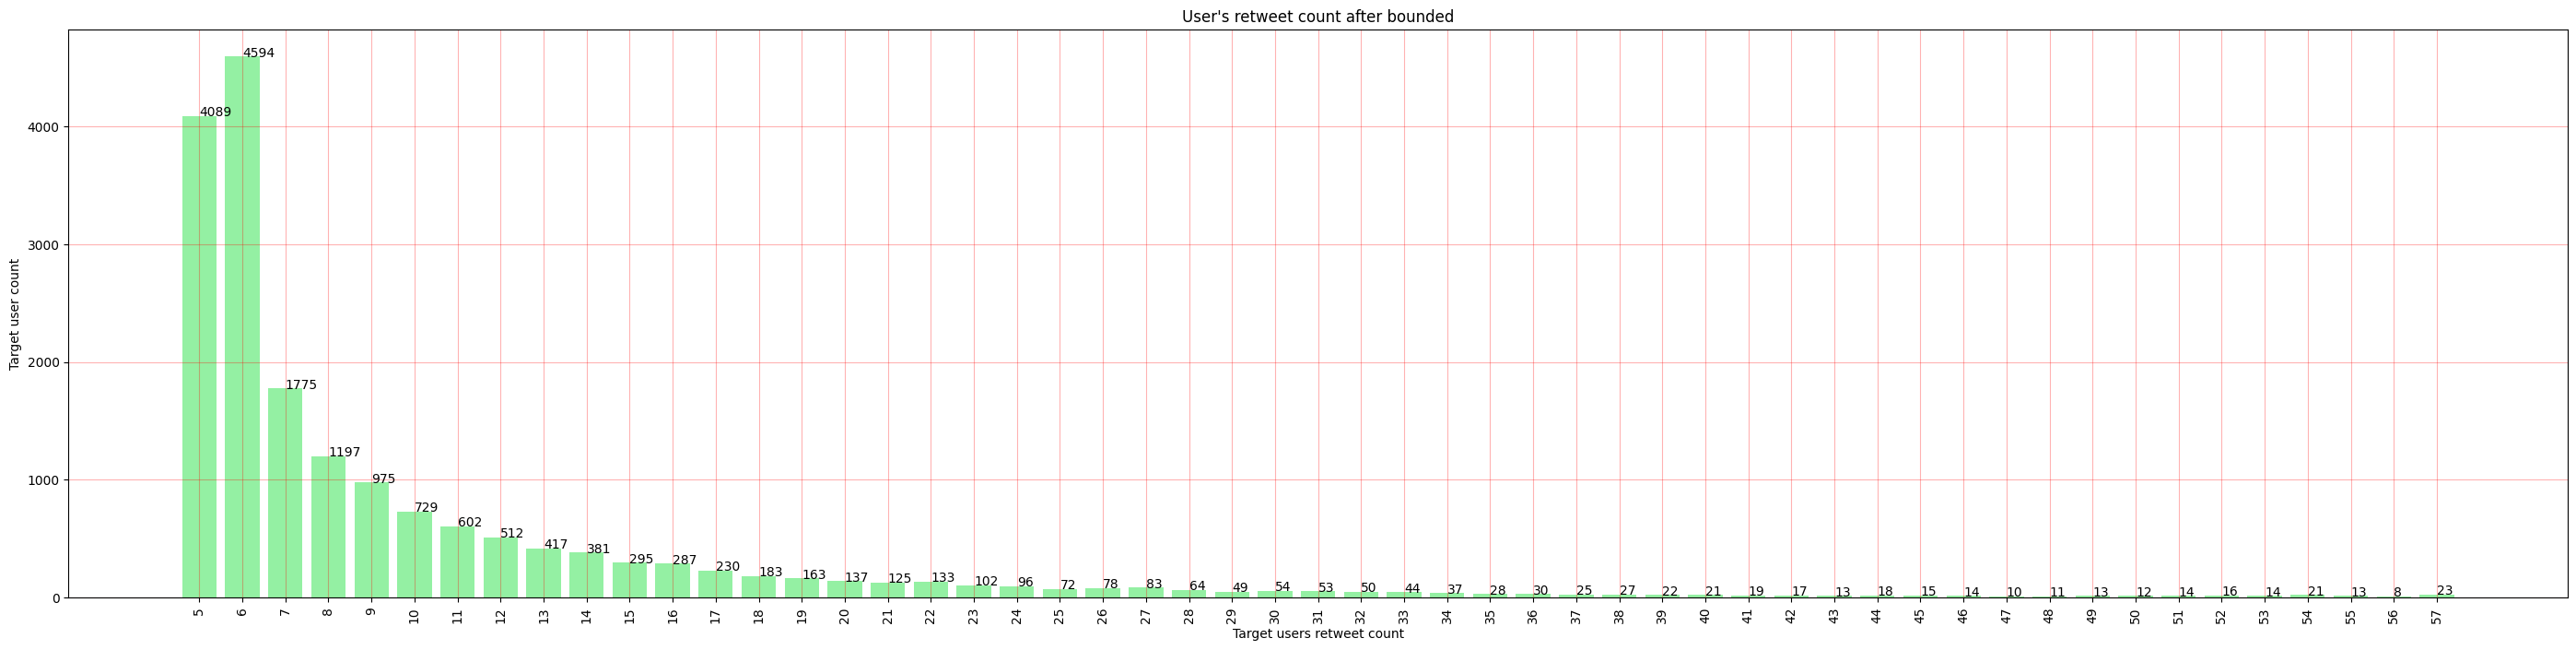

In [12]:
#   Draw a bar plot to see after bounded
"""
    Set bound after observing the user's retweet counts distributionns.
    Most of the users distributed in the range of 1 to 3.
"""
bound = 4
print("Total users :", len(retweeters))
print("Deleting users of retweet counts lower than %d : %d" % (bound, sum(show_list[0:bound])))
print("Total of target users : %d" % sum(show_list[bound:]))

color = (0.3, 0.9, 0.4, 0.6)
plt.figure(figsize = (35,8))
plt.title("User's retweet count after bounded")
plt.bar(label[bound:], show_list[bound:], color=color, width=0.8, align='center')
plt.grid(True,color='r',alpha=0.3)
plt.xlabel('Target users retweet count')
plt.ylabel('Target user count')
plt.xticks(rotation='vertical')
for index, value in enumerate(show_list[bound:]):
    plt.text(index, value, str(value))
plt.show()

In [13]:
wanna_find_target = False
target_users = list()
if wanna_find_target:   # need to run the function to find target users
    retweeters = dict(result)
    target_users = FindTargetUser_MultiCore(
        bound = bound,
        retweeters = retweeters,
    )
    target_users = sorted(target_users)
    print("Target users :", len(target_users))
    with open(file_path + "target_users.json", "w") as f:
        json.dump(target_users, f, indent=True)

else: # load the file of target users
    with open(file_path + "target_users.json", "r") as f:
        json_file = json.load(f)
        target_users = list(json_file)

In [14]:
# get tweets from the post wall of each target user.
# and dont captured those target users who already been crawed.
TargetUser_Tweets = dataset.Get_User_Tweets_Multi(
    file_path=file_path,
    target_user=target_users
)
print(len(TargetUser_Tweets))


In [ ]:
# get follower list of every target users
"""
dataset.Get_Followers_Multi(
    target_users = target_users,
    file_path = file_path
)
"""


## <font color="pink"> Graph Construction </font> ##


1. 把所有 target user 的 id 一起 encoding 成 0, 1, 2, 3, ... 
   
2. 收集每個 target user 的追蹤關係後再下去比對，有出現在清單上面的 user id，就代表他們有 edge
3. 全部用 follow 的關係當 edge 建圖，會有一張 Base Graph
4. 每篇 tweet 以 base graph 為基礎來建 data graph，每一個 data graph 的區別是權重的不同
5. 如果某兩個 user 有共同轉推同一篇 tweet ，那這兩個 user 在這張 data graph 的權重 + 1


In [ ]:
retweeters_set = set() # 把 retweeters 用成集合，方便做 union
requests = int(0) # total capture requests
for tweet_id in json_file:
    retweeters = set(json_file[tweet_id])
    requests += len(retweeters)
    retweeters_set = retweeters_set.union(retweeters) # set union

plt.title('Biden dataset  ' + filename)
plt.grid(True,color='r',alpha=0.6)
v_label = 'Retweeter (' + str(len(retweeters_set)) + ')'
r_label = 'Requests (' + str(requests) + ')'
plt.bar([v_label, r_label], [len(retweeters_set), requests], color=['orange', 'blue'], width=0.4)
plt.figure(figsize = (1,2))
plt.show()

In [ ]:
# 檢查有沒有重複
print(len(retweeters_set.difference()))
retweeters_set = sorted(retweeters_set)

#### 2. Encoding
- 將所有的 retweeter <font color='#FF1212'> (vertex)</font> 的 user id encoding 成 0,1,2,3...，方便建 adjacency matrix
- json file 的 multiple objects 最前面與最後面要加中括弧[]，objects 之間要加逗號

In [ ]:

wanna_save = True
# json file 再多一個 object -> user id : following list
user_follower = dict.fromkeys(retweeters_set)

for id in user_follower.keys():
    followers = []
    for follwer in tweepy.Paginator(client.get_users_followers, id).flatten():
        followers.append(follwer.id)
    user_follower[id] = followers


In [ ]:
if wanna_save:
    with open('2022-10-06_followers.json', 'w') as f: # 這裡記得改掉 不然又寫錯
        foller_json = json.dumps(user_follower)
        f.write(foller_json)

> 接下來要將 user's 的 followers，跟 retweeters_set 做比較，不在 retweeter_set 裡面的 id 直接踢掉
> 
> 剩下來的存起來，用來建 edge list

In [ ]:
encoding_table = dict()
for i,j in zip(retweeters_set, range(len(retweeters_set))):
    encoding_table[i] = j